This file analyze the results for regression.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from pathlib import Path
from pprint import pprint
from scipy.io import loadmat
from tqdm import trange, tqdm
from scipy.stats import ttest_ind
from collections import defaultdict as ddict
from easydict import EasyDict as edict

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [2]:
# import my own functions
import sys
sys.path.append("../../mypkg")
import importlib

# paras
import paras
importlib.reload(paras);
from paras import paras

# some useful constants
import constants
importlib.reload(constants)
from constants import REGION_NAMES, REGION_NAMES_WLOBE, RES_ROOT, DATA_ROOT

In [3]:
# utils
import utils.matrix
importlib.reload(utils.matrix)
from utils.matrix import eig_sorted

import utils.misc
importlib.reload(utils.misc)
from utils.misc import paras2name, cumsum_cutoff, save_pkl_dict2folder, load_pkl_folder2dict

import utils.projection
importlib.reload(utils.projection)
from utils.projection import euclidean_proj_l1ball

import utils.standardize
importlib.reload(utils.standardize)
from utils.standardize import minmax, minmax_mat, minmax_pn

import utils.brain_plot
importlib.reload(utils.brain_plot)
from utils.brain_plot import reorder_U, U_2brain_vec

## Parameters

In [4]:
pprint(paras)

{'Cs': array([1.0e+02, 2.5e+01, 1.0e+01, 5.0e+00, 2.0e+00, 1.0e+00, 5.0e-01,
       2.0e-01, 1.0e-01, 5.0e-02, 1.0e-02]),
 'L': 100.0,
 'Lmin': 200,
 'T': 2,
 'cur_dir': PosixPath('/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg'),
 'cutoff': 0.6,
 'data_dir': PosixPath('../data'),
 'decimate_rate': 5,
 'downsample_rate': 20,
 'fct': 0.5,
 'fig_dir': PosixPath('../figs'),
 'is_detrend': True,
 'kappa': 3.21,
 'kps': array([1.        , 1.003003  , 1.00600601, 1.00900901, 1.01201201,
       1.01501502, 1.01801802, 1.02102102, 1.02402402, 1.02702703,
       1.03003003, 1.03303303, 1.03603604, 1.03903904, 1.04204204,
       1.04504505, 1.04804805, 1.05105105, 1.05405405, 1.05705706,
       1.06006006, 1.06306306, 1.06606607, 1.06906907, 1.07207207,
       1.07507508, 1.07807808, 1.08108108, 1.08408408, 1.08708709,
       1.09009009, 1.09309309, 1.0960961 , 1.0990991 , 1.1021021 ,
       1.10510511, 1.10810811, 1.11111111, 1.11411411, 1.11711712,
       1.12012

In [5]:
# this parameters only for this file
_paras = edict()
_paras.folder_name = "method_eig"
_paras.save_dir = RES_ROOT/_paras.folder_name
print(f"Load results to {_paras.save_dir}")

Load results to /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig


## Load results

In [17]:
# load results
cur_res = load_pkl_folder2dict(_paras.save_dir)

Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/Amat_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/Amat_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dim_redu_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dim_redu_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/can_pts_ctrls.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/can_pts_AD

In [7]:
pprint(cur_res.keys())

dict_keys(['dXXmats_AD', 'dXXmats_ctrl', 'Amat_AD', 'Amat_ctrl', 'dim_redu_ctrl', 'dim_redu_AD', 'can_pts_ctrls', 'can_pts_ADs', 'cpts_ctrls', 'cpts_ADs', 'post_paras', 'eig_vals_ADs', 'cpts_ADs_selected', 'dwells_ADs_selected', 'eig_vals_ctrls', 'cpts_ctrls_selected', 'dwells_ctrls_selected'])


## get the dataset

In [8]:
ncpts_ADs_selected = [len(cpts) for cpts in cur_res.cpts_ADs_selected]
ncpts_ctrls_selected = [len(cpts) for cpts in cur_res.cpts_ctrls_selected]

In [135]:
# selected U and calculate weighted U (ABS wU)
wUs_abs_AD = []
wUs_abs_mean_AD = []
wUs_abs_max_AD = []
ws_abs_mean_AD = []
ws_abs_max_AD = []
for ix in range(len(cur_res.eig_vals_ADs)):
    cur_eig_val_abs = np.abs(cur_res.eig_vals_ADs[ix])
    cur_dwells = cur_res.dwells_ADs_selected[ix]
    
    cur_ws_abs = cur_eig_val_abs
    cur_Us_abs = np.abs(cur_res.dim_redu_ctrl.eigVecs[:, :cur_res.post_paras.ctrl_r])
    
    cur_wUs_abs = np.matmul(cur_Us_abs, cur_ws_abs)
    cur_wUs_abs_mean = cur_wUs_abs.mean(axis=1)
    
    wUs_abs_AD.append(cur_wUs_abs)
    wUs_abs_max_AD.append(cur_wUs_abs[:, np.argmax(cur_dwells)])
    wUs_abs_mean_AD.append(cur_wUs_abs_mean)
    ws_abs_mean_AD.append(cur_eig_val_abs[:, :].mean())
    ws_abs_max_AD.append(cur_eig_val_abs[:, :].max())
    
wUs_abs_ctrl = []
wUs_abs_mean_ctrl = []
wUs_abs_max_ctrl = []
ws_abs_mean_ctrl = []
ws_abs_max_ctrl = []
for ix in range(len(cur_res.eig_vals_ctrls)):
    cur_eig_val_abs = np.abs(cur_res.eig_vals_ctrls[ix])
    cur_dwells = cur_res.dwells_ctrls_selected[ix]
    
    cur_ws_abs = cur_eig_val_abs
    cur_Us_abs = np.abs(cur_res.dim_redu_AD.eigVecs[:, :cur_res.post_paras.AD_r])
    
    cur_wUs_abs = np.matmul(cur_Us_abs, cur_ws_abs)
    cur_wUs_abs_mean = cur_wUs_abs.mean(axis=1)
    
    wUs_abs_ctrl.append(cur_wUs_abs)
    wUs_abs_max_ctrl.append(cur_wUs_abs[:, np.argmax(cur_dwells)])
    wUs_abs_mean_ctrl.append(cur_wUs_abs_mean)
    ws_abs_mean_ctrl.append(cur_eig_val_abs[:, :].mean())
    ws_abs_max_ctrl.append(cur_eig_val_abs[:, :].max())
    
wUs_abs_mean_AD = np.array(wUs_abs_mean_AD)
wUs_abs_mean_ctrl = np.array(wUs_abs_mean_ctrl)
wUs_abs_max_AD = np.array(wUs_abs_max_AD)
wUs_abs_max_ctrl = np.array(wUs_abs_max_ctrl)

## Regression 

In [136]:
import numbers
# return the predicted probs for each test obs
def clf_2probs(clf, X_test):
    probs = clf.predict_proba(X_test)
    return probs[:, clf.classes_==1].reshape(-1)

def LOO_pred_givenC(cur_X, cur_Y, Cs=1, is_prg=True):
    probs = []
    if is_prg:
        prog_bar = trange(len(cur_Y))
    else:
        prog_bar = range(len(cur_Y))
    if isinstance(Cs, numbers.Number):
        Cs = np.ones_like(cur_Y)*Cs
    for ix in prog_bar:
        cur_X_test = cur_X[ix, :].reshape(1, -1)
        cur_Y_test = cur_Y[ix].reshape(1, -1)
        cur_X_train = np.delete(cur_X, ix, axis=0)
        cur_Y_train = np.delete(cur_Y, ix)
        clf = LogisticRegression(random_state=0, C=Cs[ix], penalty="l2", solver="liblinear").fit(cur_X_train, cur_Y_train)
        #clf = RandomForestClassifier(random_state=0).fit(cur_X_train, cur_Y_train)
        #clf = DecisionTreeClassifier(random_state=0).fit(cur_X_train, cur_Y_train)
        probs.append(clf_2probs(clf, cur_X_test))
    return np.array(probs).reshape(-1)

In [137]:
def LOO_bestC(cur_X, cur_Y, Cs, is_prg=0, is_C_only=1):
    Cs = np.array(Cs)
    cur_aucs = []
    if is_prg:
        prog_bar = tqdm(Cs)
    else:
        prog_bar = Cs
    for cur_C in prog_bar: 
        cur_pred_probs = LOO_pred_givenC(cur_X, cur_Y, Cs=cur_C, is_prg=0)
        cur_auc = roc_auc_score(cur_Y, cur_pred_probs)
        cur_aucs.append(cur_auc)
        cur_best_C = Cs[np.argmax(cur_aucs)]
    cur_best_C = Cs[np.argmax(cur_aucs)]
    if is_C_only:
        return cur_best_C
    else:
        return cur_best_C, cur_aucs

In [138]:
def tmp_foldwU(mat):
    assert mat.shape[-1] == 68
    mat_half = (mat[:, :34] + mat[:, 34:])/2
    return mat_half

In [139]:
cur_res.keys()

dict_keys(['dXXmats_AD', 'dXXmats_ctrl', 'Amat_AD', 'Amat_ctrl', 'dim_redu_ctrl', 'dim_redu_AD', 'can_pts_ctrls', 'can_pts_ADs', 'cpts_ctrls', 'cpts_ADs', 'post_paras', 'eig_vals_ADs', 'cpts_ADs_selected', 'dwells_ADs_selected', 'eig_vals_ctrls', 'cpts_ctrls_selected', 'dwells_ctrls_selected'])

In [140]:
# prepare for Y and X
reg_Y = np.concatenate([np.ones_like(ncpts_ADs_selected),
                        np.zeros_like(ncpts_ctrls_selected)])
reg_X_wU_abs_mean = np.concatenate([wUs_abs_mean_AD, wUs_abs_mean_ctrl], axis=0)
reg_X_wU_abs_max = np.concatenate([wUs_abs_max_AD, wUs_abs_max_ctrl], axis=0)
##reg_X_rank = np.concatenate([cur_res.rank_ADs, cur_res.rank_ctrls])
reg_X_ncpts = np.concatenate([ncpts_ADs_selected, ncpts_ctrls_selected])
reg_X_ws_max = np.concatenate([ws_abs_max_AD, ws_abs_max_ctrl])
reg_X_ws_mean = np.concatenate([ws_abs_mean_AD, ws_abs_mean_ctrl])


reg_X = np.concatenate([
                        #tmp_foldwU(reg_X_wU_abs_mean), # try minmax each row
                        reg_X_wU_abs_mean, 
                        reg_X_ncpts.reshape(-1, 1), 
                        reg_X_ws_max.reshape(-1, 1)
                       ], axis=1)
##reg_X = reg_X_wU_abs_max
reg_X_std = (reg_X - reg_X.mean(axis=0))/reg_X.std(axis=0)

### AUC under LOO

In [141]:
gopt_C = LOO_bestC(reg_X_std, reg_Y, paras.Cs, 1)
print(gopt_C, paras.Cs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.74it/s]

0.5 [1.0e+02 2.5e+01 1.0e+01 5.0e+00 2.0e+00 1.0e+00 5.0e-01 2.0e-01 1.0e-01
 5.0e-02 1.0e-02]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 831.93it/s]


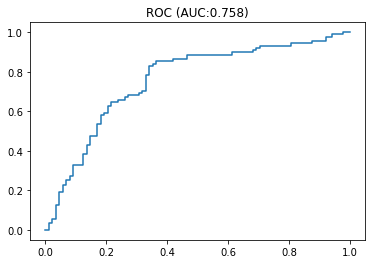

In [142]:
pred_probs = LOO_pred_givenC(reg_X_std, reg_Y, Cs=gopt_C, is_prg=1)
fpr, tpr, thresholds = roc_curve(reg_Y, pred_probs, pos_label=1)
auc = roc_auc_score(reg_Y, pred_probs)

plt.title(f"ROC (AUC:{auc:.3f})")
plt.plot(fpr, tpr)

### CV for tuning C for each Obs

In [33]:
import multiprocessing as mp
def run_fn(ix):
    cur_X_test = reg_X_std[ix, :].reshape(1, -1)
    cur_Y_test = reg_Y[ix].reshape(1, -1)
    cur_X_train = np.delete(reg_X_std, ix, axis=0)
    cur_Y_train = np.delete(reg_Y, ix)
    
    print(f"Start {ix}")
    cur_best_C =  LOO_bestC(cur_X_train, cur_Y_train, paras.Cs, 0)
    print(f"Finished {ix}")
    return (ix, cur_best_C)


if __name__ == "__main__":
    with mp.Pool(processes=20) as pool:
        res_proc = []
        for ix in range(len(reg_Y)):
            res_proc.append( pool.apply_async(run_fn, [ix,]) )
        res = [cur_proc.get() for cur_proc in res_proc] # to retrieve the results
    pool.join()

6014
25783

9101615

1112
1317


14

18
19
22


2425



In [34]:
res = sorted(res, key=lambda x:x[0])
best_Cs = [re[-1] for re in res]

probs = []
pred_probs = LOO_pred_givenC(reg_X_std, reg_Y, Cs=best_Cs, is_prg=1)
fpr, tpr, thresholds = roc_curve(reg_Y, pred_probs, pos_label=1)
auc = roc_auc_score(reg_Y, pred_probs)

plt.title(f"ROC (AUC:{auc:.3f})")
plt.plot(fpr, tpr)

### AUC under 10000 CV

In [61]:
# AUC under repetitions
np.random.seed(0)
nobs = reg_X_std.shape[0]
rep_aucs = []
for j in tqdm(range(10000)):
    test_idxs = np.random.choice(nobs, int(nobs/5), False)
    train_idxs = np.delete(np.arange(nobs), test_idxs)
    clf = LogisticRegression(penalty=paras.penalty, random_state=0, C=gopt_C)
    clf.fit(reg_X_std[train_idxs], reg_Y[train_idxs])
    cur_eprobs = clf_2probs(clf, reg_X_std[test_idxs, :])
    cur_auc = roc_auc_score(reg_Y[test_idxs], cur_eprobs)
    rep_aucs.append(cur_auc)
mean_auc = np.mean(rep_aucs)
std_auc = np.std(rep_aucs)
print(f"The mean of AUC under 1000 repetitions is {mean_auc:.3f} and the standard deviation is {std_auc:.3f}, "
      f"the 95% CI is ({np.quantile(rep_aucs, 0.025):.3f}, {np.quantile(rep_aucs, 0.975):.3f}).")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:54<00:00, 182.70it/s]

The mean of AUC under 1000 repetitions is 0.774 and the standard deviation is 0.074, the 95% CI is (0.624, 0.908).


### final fit  and bootstrap analysis

In [76]:
final_clf = LogisticRegression(random_state=0, C=gopt_C, 
                               penalty="l2").fit(reg_X_std, reg_Y)
                               #solver="liblinear").fit(reg_X_std, reg_Y)
final_coefs = final_clf.coef_.reshape(-1)

In [72]:
# bootstrap CIs
np.random.seed(1)
rep_num = 10000
parass_boot = []
for _ in trange(rep_num):
    boot_idx = np.random.choice(len(reg_Y), len(reg_Y))
    cur_Y_boot = reg_Y[boot_idx]
    cur_X_boot = reg_X_std[boot_idx]
    cur_clf = LogisticRegression(penalty=paras.penalty, random_state=0, C=gopt_C)
    cur_clf.fit(cur_X_boot, cur_Y_boot)
    paras_boot = cur_clf.coef_.reshape(-1)
    parass_boot.append(paras_boot)

  0%|▏                                                                                                                                                                      | 8/10000 [00:00<02:05, 79.48it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
  0%|▎                                                                                                                                                                     | 18/10000 [00:00<01:55, 86.33it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: 

  2%|██▊                                                                                                                                                                  | 168/10000 [00:01<01:50, 88.62it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
  2%|███▎                                                                                                                                                                 | 197/10000 [00:02<01:49, 89.54it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: 

  4%|██████▉                                                                                                                                                              | 418/10000 [00:04<01:41, 94.19it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
  4%|███████▏                                                                                                                                                             | 438/10000 [00:04<01:46, 89.98it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: 

  6%|█████████▋                                                                                                                                                           | 590/10000 [00:06<01:44, 90.15it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
  6%|█████████▉                                                                                                                                                           | 600/10000 [00:06<01:43, 91.23it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: 

  8%|█████████████▏                                                                                                                                                       | 800/10000 [00:08<01:38, 93.35it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.or

Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_45725/4012789445.py", line 10, in <module>
    cur_clf.fit(cur_X_boot, cur_Y_boot)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1406, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = Immediat

TypeError: object of type 'NoneType' has no len()

In [64]:
parass_boot = np.array(parass_boot)
# 95% CIs
lows, ups = final_coefs-parass_boot.std(axis=0)*1.96, final_coefs+parass_boot.std(axis=0)*1.96
keep_idx_boot = np.bitwise_or(lows >0,  ups < 0)
keep_idx_id_boot =  np.where(keep_idx_boot)[0]

# Pvalue
test_stat_boot = final_coefs/parass_boot.std(axis=0)
norm_rv = scipy.stats.norm()
# to be consistent, I think we should use two-sided pvalue
boot_pvs = 2*(1-norm_rv.cdf(np.abs(test_stat_boot)))

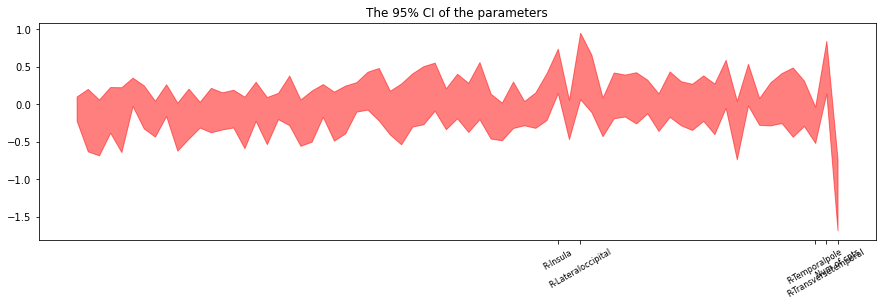

In [65]:
xlabs = np.concatenate([REGION_NAMES, ["Num of cpts"]])
plt.figure(figsize=[15, 4])
plt.fill_between(list(range(len(lows))), lows, ups, color="red", alpha=.5)
plt.title("The 95% CI of the parameters")
_ = plt.xticks(keep_idx_id_boot, xlabs[keep_idx_id_boot], rotation=30, fontsize=8)

In [66]:
# Bootstrap p value and CI are consistent
tmp_idx = np.bitwise_xor(boot_pvs <= 0.05, keep_idx_boot)
res_tb = {
   "Feature" : xlabs[tmp_idx],  
    "Parameters": final_coefs[tmp_idx],
    "Lower": lows[tmp_idx],
    "Upper": ups[tmp_idx],
    "Pvalues": boot_pvs[tmp_idx]
}
pd.set_option("display.precision", 3)
res_tb = pd.DataFrame(res_tb)
print(res_tb)

Empty DataFrame
Columns: [Feature, Parameters, Lower, Upper, Pvalues]
Index: []


In [67]:
#  output table
res_tb = {
   "Feature" : xlabs[keep_idx_boot],  
    "Parameters": final_coefs[keep_idx_boot],
    "Lower": lows[keep_idx_boot],
    "Upper": ups[keep_idx_boot],
    "Pvalues": boot_pvs[keep_idx_boot]
}
#pd.set_option("display.precision", 3)
pd.set_option('display.float_format',lambda x : '%.4f' % x)
res_tb = pd.DataFrame(res_tb)
print(res_tb)

                Feature  Parameters   Lower   Upper  Pvalues
0              R-Insula      0.4467  0.1502  0.7431   0.0031
1    R-Lateraloccipital      0.5125  0.0687  0.9562   0.0236
2        R-Temporalpole     -0.2730 -0.5150 -0.0311   0.0270
3  R-Transversetemporal      0.4969  0.1457  0.8481   0.0055
4           Num of cpts     -1.2057 -1.6819 -0.7295   0.0000


array([-0.08262448, -0.02834349, -0.0261266 , -0.0278554 ,  0.00564127,
        0.04545726, -0.00902231, -0.00249662, -0.02723813, -0.05005823,
        0.00472024,  0.0130822 , -0.00558937,  0.00220457, -0.02517485,
        0.0291409 ,  0.00013222, -0.01644167, -0.00379602,  0.02056224,
        0.00881285, -0.03270575, -0.02042375,  0.02348026, -0.00080144,
       -0.00931711, -0.02866523,  0.01743452,  0.01642715,  0.00361262,
        0.0193878 , -0.03602023, -0.04750996, -0.01880329, -0.08262448,
       -0.02834349, -0.0261266 , -0.0278554 ,  0.00564127,  0.04545726,
       -0.00902231, -0.00249662, -0.02723813, -0.05005823,  0.00472024,
        0.0130822 , -0.00558937,  0.00220457, -0.02517485,  0.0291409 ,
        0.00013222, -0.01644167, -0.00379602,  0.02056224,  0.00881285,
       -0.03270575, -0.02042375,  0.02348026, -0.00080144, -0.00931711,
       -0.02866523,  0.01743452,  0.01642715,  0.00361262,  0.0193878 ,
       -0.03602023, -0.04750996, -0.01880329])

In [201]:
# final parameter, no abs, remove pv <0.05
mm_pn_paras = minmax(np.abs(np.concatenate([final_coefs[:34], final_coefs[:34]])))
nlog_pvs = -np.log10(np.concatenate([boot_pvs[:34], boot_pvs[:34]]))
mm_pn_paras[nlog_pvs < -np.log10(0.05)] = 0
out_paras = U_2brain_vec(reorder_U(mm_pn_paras))
print(np.sum(mm_pn_paras ==0), np.sum(nlog_pvs < -np.log10(0.05)))
np.savetxt(RES_ROOT/f"./{_paras.folder_name}/abs_paras_part.txt", out_paras)
#pd.DataFrame({"Name": REGION_NAMES, 
#              "Vec": mm_pn_paras}).to_csv(RES_ROOT/f"./{_paras.folder_name}/abs_paras.csv", 
#                                          index=False)

54 54


In [202]:
mm_pn_paras

array([1.        , 0.34198691, 0.        , 0.        , 0.        ,
       0.54944602, 0.        , 0.        , 0.32858733, 0.6052206 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.35165341, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.57432948, 0.        , 1.        ,
       0.34198691, 0.        , 0.        , 0.        , 0.54944602,
       0.        , 0.        , 0.32858733, 0.6052206 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.35165341,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.57432948, 0.        ])

In [197]:
# final parameter, no abs, remove pv <0.05
mm_pn_paras = minmax(np.abs(final_coefs[:68]))
nlog_pvs = -np.log10(boot_pvs[:68])
mm_pn_paras[nlog_pvs < -np.log10(0.05)] = 0
out_paras = U_2brain_vec(reorder_U(mm_pn_paras))
print(np.sum(mm_pn_paras ==0), np.sum(nlog_pvs < -np.log10(0.05)))
np.savetxt(RES_ROOT/f"./{_paras.folder_name}/abs_paras.txt", out_paras)
#pd.DataFrame({"Name": REGION_NAMES, 
#              "Vec": mm_pn_paras}).to_csv(RES_ROOT/f"./{_paras.folder_name}/abs_paras.csv", 
#                                          index=False)

/tmp/ipykernel_33647/1550494128.py:3: RuntimeWarning: divide by zero encountered in log10
  nlog_pvs = -np.log10(boot_pvs[:68])


ValueError: could not broadcast input array from shape (34,) into shape (19,)